In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def findnanrows(df):
    is_NaN = df.isnull() 
    row_has_NaN = is_NaN.any(axis=1) 
    rows_with_NaN = df[row_has_NaN] 
    return rows_with_NaN

def interpolatedata(df):
    filldf = df.groupby(pd.Grouper(freq='10T')).mean()
    dfnan = findnanrows(filldf)
    print("==> %s rows have been filled <==" %len(dfnan))
    filldf = filldf.interpolate().round(2)
    return filldf

In [3]:
def loaddata(sartyear, endyear):
    urlpath = 'https://www.bgc-jena.mpg.de/wetter/'
    urllist = []
    df = pd.DataFrame()
    for year in np.arange(sartyear, endyear, 1):
        urllist.append(urlpath+"mpi_roof_"+str(year)+"a.zip")
        urllist.append(urlpath+"mpi_roof_"+str(year)+"b.zip")
    for url in urllist:
        df = df.append(pd.read_csv(url, encoding='unicode_escape', parse_dates=True, index_col="Date Time"))
    df.index.name = 'datetime'
    return df

raw_data = loaddata(sartyear=2018, endyear=2021)

/var/folders/fq/s6_sst4x3cv_zj9lkplg7f640000gn/T/ipykernel_40762/920423209.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.read_csv(url, encoding='unicode_escape', parse_dates=True, index_col="Date Time"))
/var/folders/fq/s6_sst4x3cv_zj9lkplg7f640000gn/T/ipykernel_40762/920423209.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.read_csv(url, encoding='unicode_escape', parse_dates=True, index_col="Date Time"))
/var/folders/fq/s6_sst4x3cv_zj9lkplg7f640000gn/T/ipykernel_40762/920423209.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.read_csv(url, encoding='unicode_escape', parse_dates=True, index_col="Date Time"))
/var/folders/fq/s6_sst4x3cv_zj9lkplg7f640000gn/T/

In [4]:
# raw dataset shape
raw_data.shape

(157773, 21)

In [5]:
# NA observations
findnanrows(raw_data)

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),...,wv (m/s),max. wv (m/s),wd (deg),rain (mm),raining (s),SWDR (W/m²),PAR (µmol/m²/s),max. PAR (µmol/m²/s),Tlog (degC),CO2 (ppm)
datetime,,,,,,,,,,,,,,,,,,,,,


In [6]:
raw_data.to_csv("raw_dataset.csv")

In [7]:
df = interpolatedata(raw_data)

==> 52 rows have been filled <==


In [8]:
df.shape

(157824, 21)

In [9]:
date_range = pd.date_range(start="2018-01-01 00:10:00", end="2021-01-01 00:00:00", freq="10T")
df.insert(0, "date", date_range)

In [10]:
df = df.reset_index()

In [11]:
df = df.iloc[:, 1:]

In [12]:
df = df.set_index('date')

In [13]:
hourly_df = df.resample("60T").mean()

In [14]:
hourly_df.shape

(26305, 21)

In [15]:
hourly_df["wv (m/s)"].describe()

count    26305.000000
mean         2.057395
std         10.387628
min      -1664.906667
25%          0.993333
50%          1.740000
75%          2.813333
max         13.215000
Name: wv (m/s), dtype: float64

In [16]:
mean_wind = hourly_df["wv (m/s)"].mean()
min_wind = hourly_df["wv (m/s)"].min()
hourly_df["wv (m/s)"] = hourly_df["wv (m/s)"].replace(min_wind, mean_wind)

In [17]:
hourly_df = hourly_df.reset_index()

In [18]:
hourly_df.to_csv("hourly_df.csv")

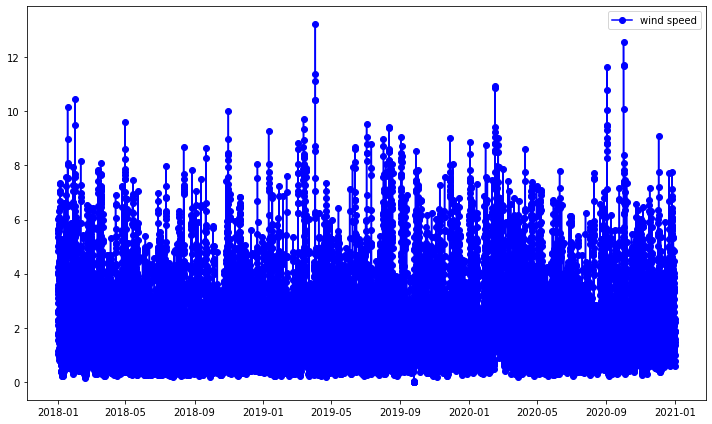

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(hourly_df['date'], hourly_df["wv (m/s)"], marker='o', linestyle='-', color='b', label='wind speed')
plt.legend()
plt.tight_layout()
plt.show()